In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os, PIL, pathlib
import numpy as np
import warnings
from tensorflow import keras

warnings.filterwarnings('ignore')

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [5]:
data_dir = '26-data'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*')))
print('图片总数为:', image_count)

图片总数为: 13403


In [7]:
batch_size = 16
img_height = 50
img_width = 50

In [13]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 13403 files belonging to 2 classes.
Using 10723 files for training.
Found 13403 files belonging to 2 classes.
Using 2680 files for validation.


In [15]:
class_names = train_ds.class_names

print(class_names)

['0', '1']


In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 50, 50, 3)
(16,)


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

def train_preprocessing(image, label):
    return (image/255.0, label)

train_ds = (
    train_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)
    # .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

val_ds = (
    val_ds.cache()
    .shuffle(1000)
    .map(train_preprocessing)
    # .batch(batch_size)
    .prefetch(buffer_size=AUTOTUNE)
)

2025-08-29 10:13:37.026482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


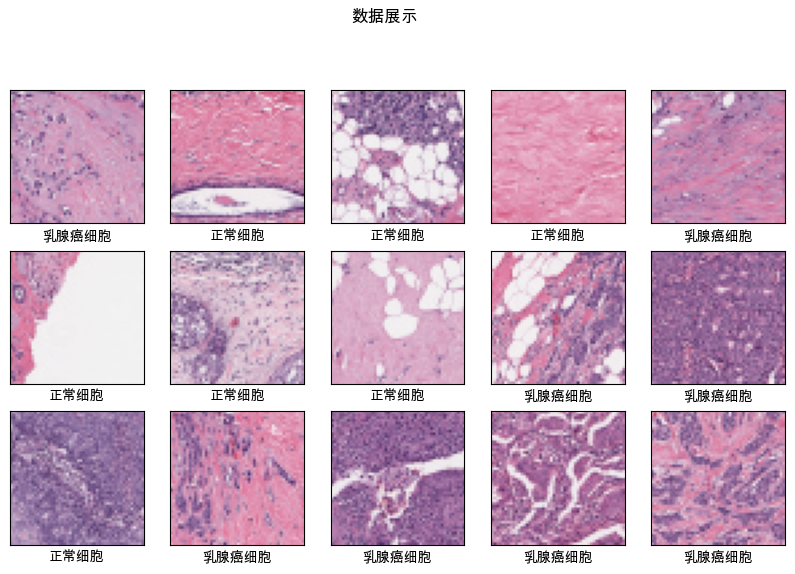

In [61]:
plt.figure(figsize=(10, 8))
plt.suptitle('数据展示')

class_names = ['乳腺癌细胞', '正常细胞']

for image, labels in train_ds.take(1):
    for i in range(15):
        plt.subplot(4, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image[i])
        plt.xlabel(class_names[labels[i]-1])

plt.show()

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=[img_width, img_height, 3]),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),

    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,562 (33.45 KB)

 Trainable params: 8,562 (33.45 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

NO_EPOCHS = 100
PATIENCE = 5
VERBOSE = 1


annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))

earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)

checkpointer = ModelCheckpoint('best_25_model.weights.h5',
                               monitor='val_accuracy',
                               verbose=VERBOSE,
                               save_best_only=True,
                               save_weights_only=True)

In [41]:
train_model = model.fit(train_ds, epochs=NO_EPOCHS, verbose=1,
                        validation_data=val_ds, callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6935 - loss: 0.5786
Epoch 1: val_accuracy improved from None to 0.76381, saving model to best_25_model.weights.h5
671/671 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7517 - loss: 0.5152 - val_accuracy: 0.7638 - val_loss: 0.5206 - learning_rate: 3.6603e-04
Epoch 2/100
671/671 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8040 - loss: 0.4504
Epoch 2: val_accuracy improved from 0.76381 to 0.81828, saving model to best_25_model.weights.h5
671/671 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8083 - loss: 0.4440 - val_accuracy: 0.8183 - val_loss: 0.4443 - learning_rate: 3.6237e-04
Epoch 3/100
667/671 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8211 - loss: 0.4153
Epoch 3: val_accuracy improved from 0.81828 to 0.82537, saving model to best_25_model.weights.h5
671/671 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8130 - loss: 0.4247 - val_accuracy: 0.8254 - val_loss: 0.4260 - learning_rate: 3.5875e-04
Epoch 4

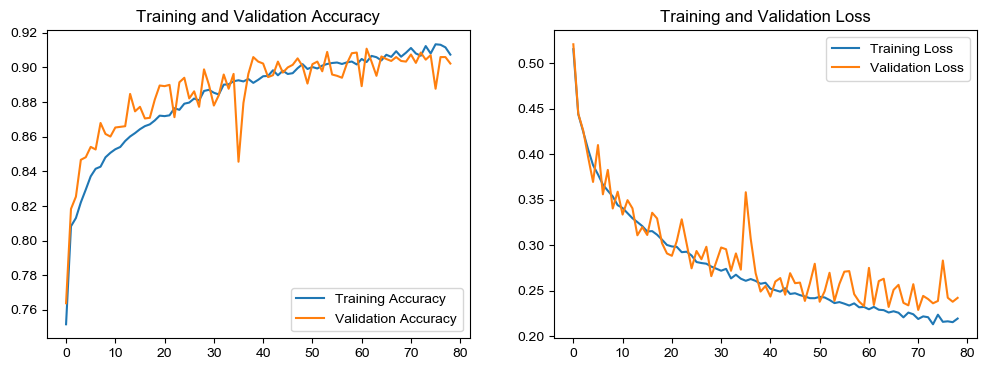

In [59]:
acc = train_model.history['accuracy']
val_acc = train_model.history['val_accuracy']

loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def plot_cm(labels, predictions):
    conf_numpy = confusion_matrix(labels, predictions)
    conf_df = pd.DataFrame(conf_numpy, index=class_names, columns=class_names)
    plt.figure(figsize=(8, 7))
    sns.heatmap(conf_df, annot=True, fmt='d', cmap='BuPu')
    plt.title('混淆矩阵', fontsize=15)
    plt.ylabel('真实值', fontsize=14)
    plt.xlabel('预测值', fontsize=14)

In [55]:
val_pre = []
val_label = []

for images, labels in val_ds.take(1):
    for image, label in zip(images, labels):
        img_array = tf.expand_dims(image, 0)
        prediction = model.predict(img_array)
        val_pre.append(class_names[np.argmax(prediction)])
        val_label.append(class_names[label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


2025-08-29 10:13:10.446463: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


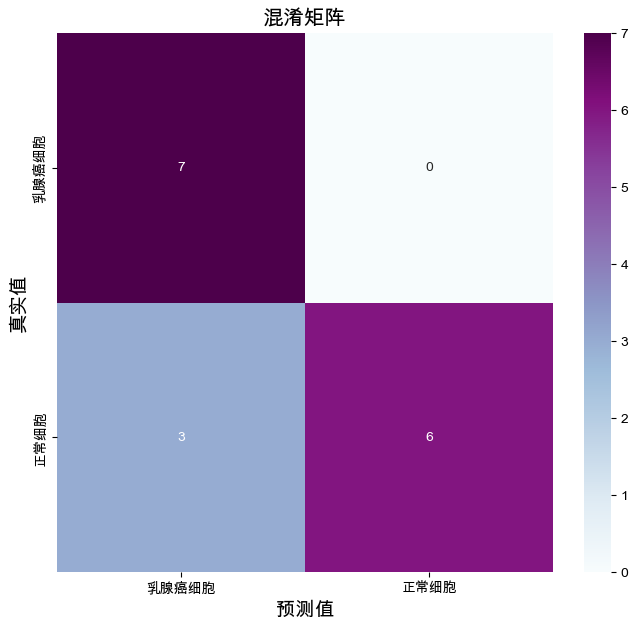

In [57]:
plot_cm(val_label, val_pre)

In [53]:
from sklearn import metrics

def test_accuracy_report(model):
    print(metrics.classification_report(val_label, val_pre, target_names=class_names))
    score = model.evaluate(val_ds, verbose=0)
    print('Loss function: %s, accuracy:' % score[0], score[1])

test_accuracy_report(model)

              precision    recall  f1-score   support

       乳腺癌细胞       0.89      0.92      0.90      1339
        正常细胞       0.92      0.88      0.90      1341

    accuracy                           0.90      2680
   macro avg       0.90      0.90      0.90      2680
weighted avg       0.90      0.90      0.90      2680

Loss function: 0.24228380620479584, accuracy: 0.9022387862205505
